# Deliverable 6.1 | Robust Tube MPC Controller for sys_z

## Design Procedure and Tuning Parameters

We design a **tube MPC controller** for the z-subsystem to handle model mismatch disturbances $w \in \mathcal{W} = [-15, 5]$.

### System Setup
- **States**: $\Delta x_z = [v_z, z]^T$ (vertical velocity and altitude in delta form)
- **Input**: $\Delta u_z = P_{avg}$ (average thrust in delta form)
- **Steady state**: Landing target at $z = 3$ with $P_{avg} \approx 56.67$

### Tube MPC Design Steps

1. **Input Constraints** $\mathcal{U}$: $P_{avg} \in [40, 80]$ → In delta form: $\Delta u \in [40 - u_s, 80 - u_s]$

2. **State Constraints** $\mathcal{X}$: 
   - Vertical velocity: $|v_z| \leq 10$ m/s
   - Altitude: $z \geq 0$ (with safety margin)

3. **Disturbance Set** $\mathcal{W}$: Input disturbance $w \in [-15, 5]$ mapped through $B_d$

4. **LQR Gain $K$**: Computed with tuning matrices:
   - $Q = \text{diag}([10, 100])$ — Heavy penalty on position error for accurate landing
   - $R = \text{diag}([0.1])$ — Low input penalty for aggressive control

5. **Minimal Robust Positively Invariant (mRPI) Set $\mathcal{E}$**: 
   - Computed iteratively: $\mathcal{E} = \bigoplus_{i=0}^{\infty} A_{cl}^i \mathcal{W}$
   - Terminates when $\|A_{cl}^i\|_2 < 10^{-2}$

6. **Tightened Constraints**:
   - $\tilde{\mathcal{X}} = \mathcal{X} \ominus \mathcal{E}$
   - $\tilde{\mathcal{U}} = \mathcal{U} \ominus K\mathcal{E}$

7. **Terminal Set $\tilde{\mathcal{X}}_f$**: Maximal invariant set for the closed-loop system under tightened constraints

### Control Law
At each step, solve for nominal trajectory $(z_k, v_k)$ and apply:
$$u = v_0 + K(x - z_0) + u_s$$

In [6]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
from LandMPC_template.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *

# Require ipympl
%matplotlib widget 

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7 # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

sim_time = 15
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10])
x_ref = np.array([0.]*9 + [1., 0., 3.])

xs, us = rocket.trim(x_ref)
print("Linearization around a steady state:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)
sys = rocket.linearize_sys(xs, us)
A, B = sys.A, sys.B

H = 7.0
mpc = MPCControl_z(A, B, xs, us, Ts, H)

Linearization around a steady state:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
mRPI set converged after 66 iterations.
Max invariant set converged after 24 iterations.


## Invariant Sets and Tightened Constraints

Below we plot the **minimal robust positively invariant (mRPI) set** $\mathcal{E}$ and the **terminal set** $\tilde{\mathcal{X}}_f$, along with the tightened input constraints $\tilde{\mathcal{U}}$.


Could not plot set: We can only plot pointed polyhedra (those with at least one vertex).
Set Diagnostics:
E (mRPI): vertices=True
X: vertices=True
X_tilde: vertices=True
Xf_tilde: vertices=False


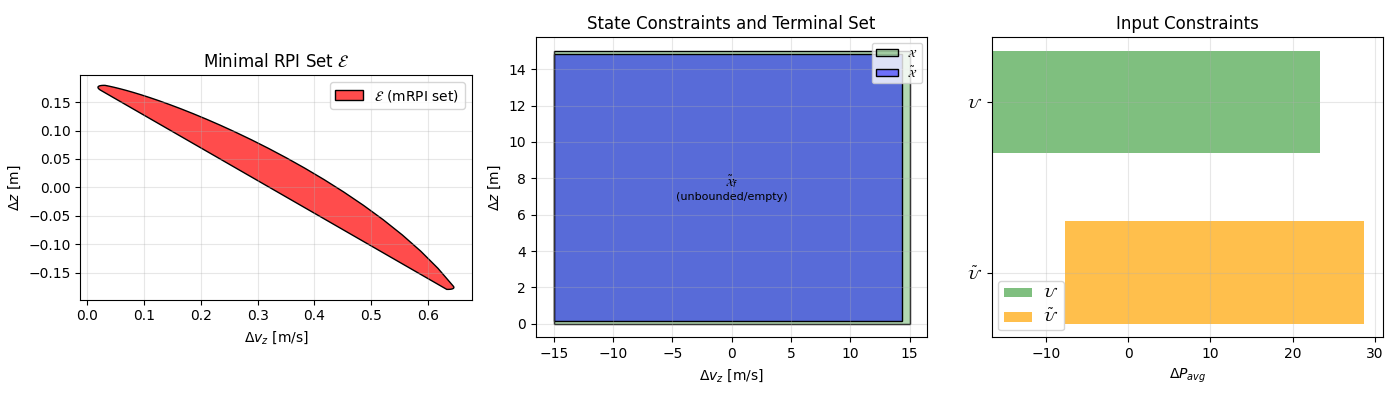


Tightened Input Constraint Vertices (in delta form):
U_tilde vertices (delta): [-7.6581225  28.73839029]

In absolute form (adding u_s = 56.67):
Tightened: P_avg ∈ [49.01, 85.41]
Original:  P_avg ∈ [40.00, 80.00]
⚠ Warning: Tightened constraints exceed original bounds!
  This may indicate the mRPI set is too large.


In [8]:
import matplotlib.pyplot as plt
from mpt4py import Polyhedron
from matplotlib.patches import Polygon as MplPolygon

# Create figure with subplots for the invariant sets
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Minimal Robust Positively Invariant Set E
ax1 = axes[0]
mpc.E.plot(ax1, color='red', opacity=0.7, label=r'$\mathcal{E}$ (mRPI set)')
ax1.set_xlabel(r'$\Delta v_z$ [m/s]')
ax1.set_ylabel(r'$\Delta z$ [m]')
ax1.set_title(r'Minimal RPI Set $\mathcal{E}$')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal')

# Plot 2: Terminal Set Xf_tilde with state constraints
ax2 = axes[1]

# Helper function to safely plot polyhedra (handling unbounded sets)
def safe_plot_polyhedron(poly, ax, z_max=20.0, **kwargs):
    """Plot a polyhedron, bounding it if necessary."""
    try:
        # Try direct plotting first
        poly.plot(ax, **kwargs)
    except:
        # If it fails, try bounding the set
        try:
            bounding_box = Polyhedron.from_Hrep(
                np.array([[0.0, 1.0], [0.0, -1.0], [1.0, 0.0], [-1.0, 0.0]]),
                np.array([z_max, z_max, 20.0, 20.0])
            )
            bounded = poly.intersect(bounding_box)
            bounded.plot(ax, **kwargs)
        except Exception as e:
            print(f"Could not plot set: {e}")
            # Plot as text annotation instead
            label = kwargs.get('label', 'Set')
            ax.text(0.5, 0.5, f"{label}\n(unbounded/empty)", 
                   transform=ax.transAxes, ha='center', va='center', fontsize=8)

# Plot the sets
safe_plot_polyhedron(mpc.X, ax2, label=r'$\mathcal{X}$', color='green', opacity=0.3)
safe_plot_polyhedron(mpc.X_tilde, ax2, label=r'$\tilde{\mathcal{X}}$', color='blue', opacity=0.5)
safe_plot_polyhedron(mpc.Xf_tilde, ax2, label=r'$\tilde{\mathcal{X}}_f$', color='purple', opacity=0.7)

ax2.set_xlabel(r'$\Delta v_z$ [m/s]')
ax2.set_ylabel(r'$\Delta z$ [m]')
ax2.set_title(r'State Constraints and Terminal Set')
ax2.legend(loc='upper right', fontsize=8)
ax2.grid(True, alpha=0.3)

# Print diagnostic info about the sets
print("="*60)
print("Set Diagnostics:")
print("="*60)
def check_set(name, poly):
    try:
        vrep = poly.Vrep
        has_vertices = vrep.V.shape[0] > 0 if vrep.V is not None else False
        has_rays = vrep.R.shape[0] > 0 if vrep.R is not None else False
        print(f"{name}: vertices={has_vertices}, rays={has_rays} (unbounded)" if has_rays else f"{name}: vertices={has_vertices}")
    except Exception as e:
        print(f"{name}: Error getting Vrep - {e}")

check_set("E (mRPI)", mpc.E)
check_set("X", mpc.X)
check_set("X_tilde", mpc.X_tilde)
check_set("Xf_tilde", mpc.Xf_tilde)

# Plot 3: Input constraints comparison
ax3 = axes[2]
# For 1D sets, we need to get the vertices array from Vrep.V
U_vertices = mpc.U.Vrep.V.flatten()
U_tilde_vertices = mpc.U_tilde.Vrep.V.flatten()
ax3.barh([1], [U_vertices.max() - U_vertices.min()], left=[U_vertices.min()], 
         height=0.3, color='green', alpha=0.5, label=r'$\mathcal{U}$')
ax3.barh([0.5], [U_tilde_vertices.max() - U_tilde_vertices.min()], left=[U_tilde_vertices.min()], 
         height=0.3, color='orange', alpha=0.7, label=r'$\tilde{\mathcal{U}}$')
ax3.set_xlabel(r'$\Delta P_{avg}$')
ax3.set_yticks([0.5, 1])
ax3.set_yticklabels([r'$\tilde{\mathcal{U}}$', r'$\mathcal{U}$'])
ax3.set_title('Input Constraints')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print vertices of tightened input constraint
print("\n" + "="*60)
print("Tightened Input Constraint Vertices (in delta form):")
print("="*60)
print(f"U_tilde vertices (delta): {U_tilde_vertices}")
print(f"\nIn absolute form (adding u_s = {mpc.us[0]:.2f}):")
U_tilde_abs_min = U_tilde_vertices.min() + mpc.us[0]
U_tilde_abs_max = U_tilde_vertices.max() + mpc.us[0]
print(f"Tightened: P_avg ∈ [{U_tilde_abs_min:.2f}, {U_tilde_abs_max:.2f}]")
print(f"Original:  P_avg ∈ [40.00, 80.00]")

# Check if tightening is valid
if U_tilde_abs_min >= 40.0 and U_tilde_abs_max <= 80.0:
    print("✓ Tightened constraints are within original bounds")
else:
    print("⚠ Warning: Tightened constraints exceed original bounds!")
    print("  This may indicate the mRPI set is too large.")


## Closed-Loop Simulations

We test the robust tube MPC controller under two disturbance scenarios:
1. **Random disturbances**: $w$ sampled uniformly from $\mathcal{W} = [-15, 5]$
2. **Extreme disturbances**: Worst-case disturbance sequence

The controller should stabilize the rocket from $z = 10$ to the target $z = 3$ with settling time $\leq 4$ seconds.


### Simulation 1: No Disturbances


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

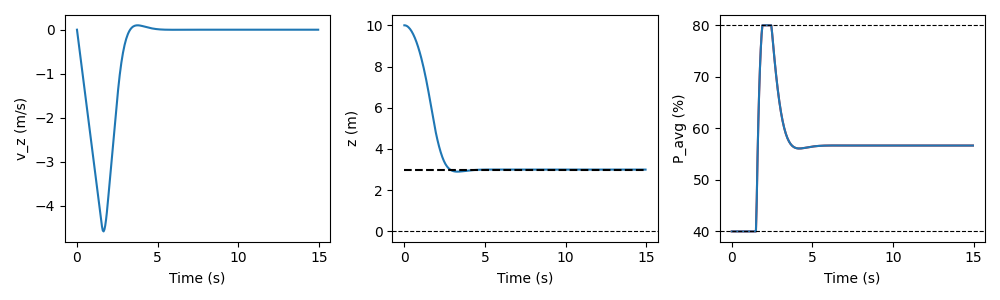

In [9]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

### Simulation 2: Extreme Disturbances


In [10]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

State violation: [vz,z]=[-3.98673071e+00 -1.76632644e-05], [LBX, UBX]=(array([-inf,   0.]), array([inf, inf]))


ValueError: Constraints violation detected, terminating...